# TRABAJO FINAL DE MAESTRIA

In [58]:

# Importar de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


In [39]:
#carga de los archivos que representan los dataset
import glob
import os

ruta_archivos = "./"  
archivos = glob.glob(os.path.join(ruta_archivos, "2025*.csv"))
print(f"Se encontraron {len(archivos)} archivos.")
df = pd.concat((pd.read_csv(f) for f in archivos), ignore_index=True)
df.head()

Se encontraron 10 archivos.


,time,phy_mcs,mac_dl_cqi,mac_dl_ri,mac_dl_pmi,mac_ul_buffer,mac_n_prb,rsrq,rsrp,rssi,dl_sinr,se,dl_bler,delay
0,1.743169e+12,0.0,9.0,1.0,3.0,4.666667,2.0,-6.700000,-88.0,-68.0,20.0,0.002000,0.0,-1.0
1,1.743169e+12,0.0,9.0,1.0,3.0,4.666667,4.0,-6.733333,-88.0,-68.0,20.0,0.008747,0.0,-1.0
2,1.743169e+12,0.0,9.0,1.0,3.0,0.000000,6.0,-6.733333,-88.0,-68.0,20.0,0.008747,0.0,-1.0
3,1.743169e+12,0.0,9.0,1.0,3.0,0.000000,12.0,-6.866667,-88.0,-68.0,20.0,0.027413,0.0,-1.0
4,1.743169e+12,0.0,9.0,1.0,3.0,0.000000,16.0,-6.866667,-88.0,-68.0,20.0,0.020667,0.0,-1.0


| Variable        | Descripción                                                                                                                                                                                                |
| --------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `time`          | Marca de tiempo en milisegundos (UNIX epoch), que indica el momento exacto de cada medición.                                                                                                               |
| `phy_mcs`       | Índice de modulación y codificación (MCS), utilizado para determinar la velocidad y calidad de transmisión en downlink. Valores más altos implican mayor velocidad, pero requieren mejor calidad de señal. |
| `mac_dl_cqi`    | Indicador de calidad del canal (CQI) en downlink, reportado por el usuario. Valores más altos indican mejor calidad de señal.                                                                              |
| `mac_dl_ri`     | Indicador de rango espacial (RI) en downlink, que representa la cantidad de flujos espaciales simultáneos soportados por la transmisión MIMO.                                                              |
| `mac_dl_pmi`    | Índice de precodificación (PMI) en downlink, que permite a la red orientar la señal hacia el usuario mediante técnicas de beamforming.                                                                     |
| `mac_ul_buffer` | Ocupación del búfer de subida (uplink) del usuario en bytes. Refleja la cantidad de datos pendientes de envío; valores altos pueden indicar congestión.                                                    |
| `mac_n_prb`     | Número de bloques de recursos físicos (PRBs) asignados al usuario en downlink para la transmisión de datos.                                                                                                |
| `rsrq`          | Calidad de señal de referencia recibida (RSRQ) en dB, considerando tanto la potencia de la señal como el ruido de fondo.                                                                                   |
| `rsrp`          | Potencia de la señal de referencia (RSRP) en dBm, sin incluir ruido; útil para evaluar cobertura en downlink.                                                                                              |
| `rssi`          | Potencia total de señal recibida (RSSI) en dBm, incluyendo tanto la señal útil como el ruido.                                                                                                              |
| `dl_sinr`       | Relación señal/interferencia+ruido (SINR) medida por el usuario en downlink. Cuanto más alta, mejor la calidad de la señal.                                                                                |
| `se`            | Eficiencia espectral en downlink, expresada en bits por segundo por hercio (bps/Hz); indica cuán eficientemente se utiliza el ancho de banda disponible.                                                   |
| `dl_bler`       | Tasa de bloques erróneos (BLER) en downlink; representa el porcentaje de bloques que deben retransmitirse por errores.                                                                                     |
| `delay`         | Retardo unidireccional del paquete RTP (latencia), en milisegundos; indica cuánto ta                                                                                                                       |


## PREPARACION DE DATOS

Dimensiones del dataset: (59798, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59798 entries, 0 to 59797
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   phy_mcs        59798 non-null  float64
 1   mac_dl_cqi     59798 non-null  float64
 2   mac_dl_ri      59798 non-null  float64
 3   mac_dl_pmi     59798 non-null  float64
 4   mac_ul_buffer  59798 non-null  float64
 5   mac_n_prb      59798 non-null  float64
 6   rsrq           59798 non-null  float64
 7   rsrp           59798 non-null  float64
 8   rssi           59798 non-null  float64
 9   dl_sinr        59798 non-null  float64
 10  se             59798 non-null  float64
 11  dl_bler        59798 non-null  float64
 12  delay          59798 non-null  float64
dtypes: float64(13)
memory usage: 5.9 MB


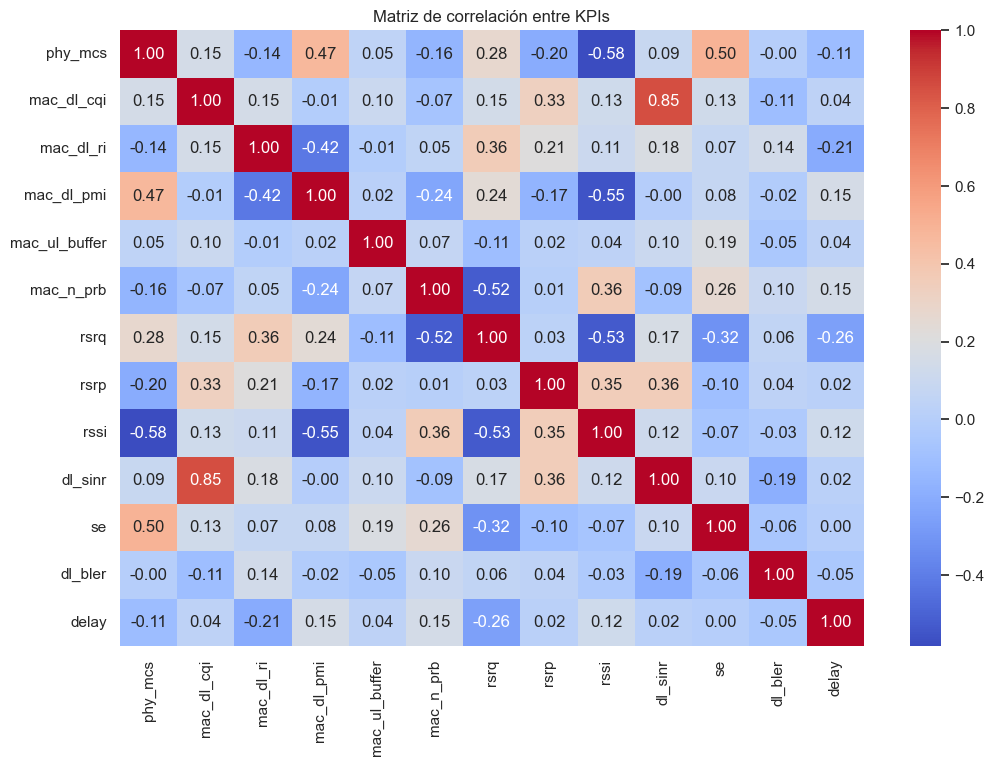

In [40]:
#eliminar variable "time"
df = df.drop(columns=['time'])
print("Dimensiones del dataset:", df.shape)
df.info()
df.describe()

# validar nulos
df.isnull().sum()

#hacer matriz de correlacion
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de correlación entre KPIs")
plt.savefig("correlacion_kpis.png", dpi=300, bbox_inches='tight') 
plt.show()


### Validación de datos Atípicos

In [41]:
def validarAtipicos(df, columnName, especification):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[columnName])
    plt.title('Diagrama de caja de ' + especification)
    plt.savefig("DiagramaCaja_"+columnName+".png", dpi=300, bbox_inches='tight')
    plt.show()
    
    Q1 = df[columnName].quantile(0.25)
    Q3 = df[columnName].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"Límite inferior: {limite_inferior}, Límite superior: {limite_superior}")
    
    outliers = df[(df[columnName] < limite_inferior) | (df[columnName] > limite_superior)]
    cantidad = len(outliers)
    porcentaje = (cantidad / len(df)) * 100
    print(f"Cantidad de registros que serían eliminados: {cantidad} / {len(df)} ({porcentaje:.2f}%)")
    
    return limite_inferior, limite_superior


def eliminarAtipicos(df, columnName, limite_inferior, limite_superior):
    df_sin_outliers = df[(df[columnName] >= limite_inferior) & (df[columnName] <= limite_superior)]
    print(f"Registros después de eliminar outliers: {len(df_sin_outliers)} / {len(df)}")
    return df_sin_outliers

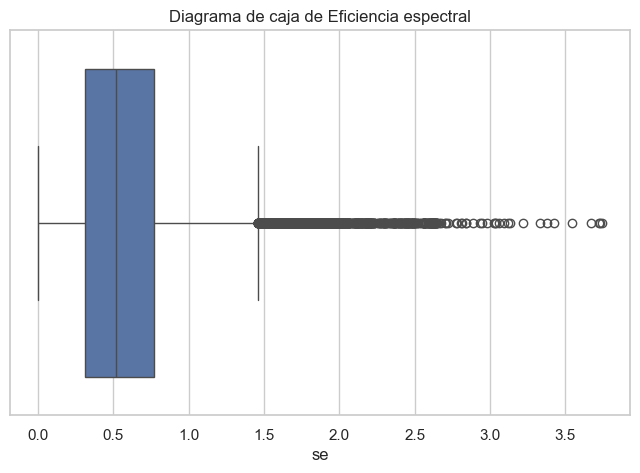

Q1: 0.31114166666666665, Q3: 0.7693866666666667, IQR: 0.458245
Límite inferior: -0.37622583333333337, Límite superior: 1.4567541666666668
Cantidad de registros que serían eliminados: 1922 / 59798 (3.21%)


In [42]:
lim_inf1, lim_sup1 = validarAtipicos(df,'se','Eficiencia espectral')

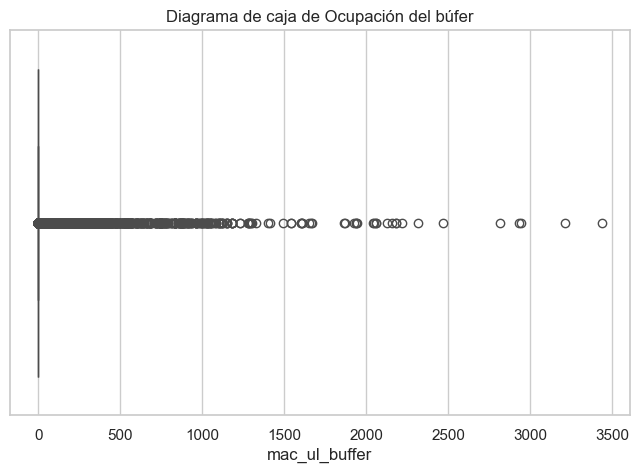

Q1: 0.0, Q3: 0.0, IQR: 0.0
Límite inferior: 0.0, Límite superior: 0.0
Cantidad de registros que serían eliminados: 14939 / 59798 (24.98%)


In [43]:
lim_inf2, lim_sup2 =validarAtipicos(df,'mac_ul_buffer','Ocupación del búfer')



*Eliminar valores atipicos*

In [44]:
df = eliminarAtipicos(df, 'se', lim_inf1, lim_sup1)

Registros después de eliminar outliers: 57876 / 59798


### Normalizar Conjunto de datos

In [45]:
scaler = MinMaxScaler()
df_normalizado = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
print(df_normalizado.head())

   phy_mcs  mac_dl_cqi  mac_dl_ri  mac_dl_pmi  mac_ul_buffer  mac_n_prb  \
0      0.0    0.692308        0.0         1.0       0.001358   0.000000   
1      0.0    0.692308        0.0         1.0       0.001358   0.086957   
2      0.0    0.692308        0.0         1.0       0.000000   0.173913   
3      0.0    0.692308        0.0         1.0       0.000000   0.434783   
4      0.0    0.692308        0.0         1.0       0.000000   0.608696   

       rsrq      rsrp  rssi   dl_sinr        se  dl_bler  delay  
0  0.960526  0.518519   0.2  0.709172  0.001373      0.0    0.0  
1  0.956140  0.518519   0.2  0.709172  0.006005      0.0    0.0  
2  0.956140  0.518519   0.2  0.709172  0.006005      0.0    0.0  
3  0.938596  0.518519   0.2  0.709172  0.018821      0.0    0.0  
4  0.938596  0.518519   0.2  0.709172  0.014189      0.0    0.0  


### Dividir el Conjunto de datos

In [50]:
X = df_normalizado.drop(columns=['se'])
y = df_normalizado['se']             
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print(f"Tamaño X_train: {X_train.shape}")
print(f"Tamaño X_val: {X_test.shape}")

Tamaño X_train: (40513, 12)
Tamaño X_val: (17363, 12)


## Entrenamiento de modelos

### REGRESION LINEAL

In [53]:
modelo_regresion = LinearRegression()
modelo_regresion.fit(X_train, y_train)
y_pred_rl = modelo_regresion.predict(X_test)
print("\nPredicciones del modelo:")
print(f"Predicciones: {y_pred_rl.round(2)}")
print(f"Valores reales: {np.array(y_test)}")
# calculo de metricas 

mae = mean_absolute_error(y_test, y_pred_rl)
mse = mean_squared_error(y_test, y_pred_rl)
rmse = np.sqrt(mse) 
r2 = r2_score(y_test, y_pred_rl)
print("Resultados de las métricas de evaluación:")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"Coeficiente de determinación (R-cuadrado): {r2:.2f}")




Predicciones del modelo:
Predicciones: [0.11 0.5  0.39 ... 0.23 0.38 0.34]
Valores reales: [0.18056194 0.39622123 0.1934787  ... 0.11140693 0.2412259  0.11336299]
Resultados de las métricas de evaluación:
Error Absoluto Medio (MAE): 0.11
Raíz del Error Cuadrático Medio (RMSE): 0.14
Coeficiente de determinación (R-cuadrado): 0.62


### RANDOM FOREST

In [56]:
modelo = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [10, 50, 100, 200],  # Cantidad de árboles
    'max_depth': [None, 5, 10, 15]     # Profundidad de cada árbol
}
grid_search = GridSearchCV(estimator=modelo, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

mejor_modelo = grid_search.best_estimator_
mejor_parametros = grid_search.best_params_
print("Mejores parámetros encontrados por Grid Search:")
print(mejor_parametros)

y_pred_rf = mejor_modelo.predict(X_test)
mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_rf)
print("\nResultados de la evaluación del mejor modelo:")
print(f"Coeficiente de determinación (R-cuadrado): {r2:.2f}")
print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")



Mejores parámetros encontrados por Grid Search:
{'max_depth': None, 'n_estimators': 200}

Resultados de la evaluación del mejor modelo:
Coeficiente de determinación (R-cuadrado): 0.89
Error Absoluto Medio (MAE): 0.04
Raíz del Error Cuadrático Medio (RMSE): 0.07


### MULTIPLAYER PERCEPTRON (MLP)

In [59]:
modelo_mlp = MLPRegressor(
    hidden_layer_sizes=(100,),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)
modelo_mlp.fit(X_train, y_train)
y_pred_mlp = modelo_mlp.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_mlp)
mse = mean_squared_error(y_test, y_pred_mlp)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_mlp)
print("Resultados de las métricas de evaluación del modelo MLP:")

print(f"Error Absoluto Medio (MAE): {mae:.2f}")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.2f}")
print(f"Coeficiente de determinación (R-cuadrado): {r2:.2f}")

Resultados de las métricas de evaluación del modelo MLP:
Error Absoluto Medio (MAE): 0.06
Raíz del Error Cuadrático Medio (RMSE): 0.09
Coeficiente de determinación (R-cuadrado): 0.84
